In [2]:
# knn, SVM, random forest
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
print("starting")
df = pandas.read_csv("corpus.csv", sep='\t', error_bad_lines=False) #ignore bad lines
print(df.columns)
print(df.shape)



/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag()

starting


Skipping line 418110: expected 18 fields, saw 22

Skipping line 470334: expected 18 fields, saw 19



Index([u'URL', u'Keywords', u'Keyword Count', u'DateTime', u'Favorite Count', u'Retweet', u'Lang', u'LinkCount', u'Link1', u'Link2', u'Link3', u'Author', u'Text', u'Followers', u'Friends', u'Location', u'Timezone', u'UTC Offset'], dtype='object')
(566337, 18)


/usr/lib/python2.7/dist-packages/pandas/io/parsers.py:1150: DtypeWarning: Columns (1,3,4,6,8,9,10,11,12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [3]:
df = df[pandas.notnull(df['Text'])]
print(df.columns)
print(df.shape)

Index([u'URL', u'Keywords', u'Keyword Count', u'DateTime', u'Favorite Count', u'Retweet', u'Lang', u'LinkCount', u'Link1', u'Link2', u'Link3', u'Author', u'Text', u'Followers', u'Friends', u'Location', u'Timezone', u'UTC Offset'], dtype='object')
(414540, 18)


In [4]:
df = df.drop_duplicates(subset = 'Text')
print(df.columns)
print(df.shape)

Index([u'URL', u'Keywords', u'Keyword Count', u'DateTime', u'Favorite Count', u'Retweet', u'Lang', u'LinkCount', u'Link1', u'Link2', u'Link3', u'Author', u'Text', u'Followers', u'Friends', u'Location', u'Timezone', u'UTC Offset'], dtype='object')
(110093, 18)


In [5]:
# 2600 tweets over 5000
# 6600 tweets over 1000
threshold = 5000
threshcount = len(df[df['Retweet'] > threshold])
from random import random
def keep(retweets):
    if retweets > threshold:
        return True
    else:
        if random() < float(threshcount) / float(len(df)-threshcount):
            return True
        else:
            return False
df = df[df['Retweet'].map(keep)]
print(threshcount)
print(df.shape)

2520
(5116, 18)


In [6]:
# set threshold for binary classifier
#retweets = df.Retweet
# train_labels = []
# for num in retweets:
#     if num >= threshold:
#         train_labels.append(1) #viral
#     else:
#         train_labels.append(0) #not viral
df['Viral'] =df['Retweet'].apply(lambda retweet: 1 if retweet >= threshold else 0)
train_labels = df.Viral.values
labels = list(set(train_labels))



In [7]:
# from feature_extractors5 import *
# url_pattern = re.compile(r'(http(s?)://)[\w./]+')
# df['Text_URL'] =df['Text'].apply(lambda doc: url_pattern.sub(lambda x: domain_name_portable(x.group()), doc))


In [28]:
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.stem.snowball import *
stemmer = SnowballStemmer('english')
from features import *
#stemmer = PorterStemmer('english')

#stopwords?
#stop = ['amp', 'cc', 'did', 'don', 'rt', 'll', 'oh', 've', 'yes', 'let', 'going', 'via', 're', 'tweet' ]
stop = []
#http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
# preProcess(str):
#     url_pattern = re.compile(r'http(s?)://[\w./]+')
#     pic_pattern = re.compile(r'pic.twitter.com/[\w.]+')
#     str = pic_pattern.sub("", str)
#     str = url_pattern.sub("", str)
#     return str
# http://shahmirj.com/blog/extracting-twitter-usertags-using-regex
class NoUrls_CountVectorizer(CountVectorizer):
    def build_preprocessor(self):
        url_pattern = re.compile(r'http(s?)://[\w./]+')
        pic_pattern = re.compile(r'pic.twitter.com/[\w.]+')
        preprocessor = super(NoUrls_CountVectorizer, self).build_preprocessor()
        return lambda doc: (pic_pattern.sub('', url_pattern.sub('', preprocessor(doc)) ))

class NoUrls_Stemmed_CountVectorizer(CountVectorizer):
    def build_preprocessor(self):
        preprocessor = super(NoUrls_Stemmed_CountVectorizer, self).build_preprocessor()
        url_pattern = re.compile(r'(http(s?)://)[\w./]+')
        #at_pattern = re.compile(r' (?<=^|(?<=[^a-zA-Z0-9-_\\.]))@([A-Za-z]+[A-Za-z0-9_]+)')
        at_pattern = re.compile(r'(^|\s)@[a-zA-Z0-9]+')
        return lambda doc: (at_pattern.sub('', url_pattern.sub("", preprocessor(doc)) ))
   #right now just doing splits on whitespace and stemming 
    def build_tokenizer(self):
        tokenizer = super(NoUrls_Stemmed_CountVectorizer, self).build_tokenizer()
        def process(word):
            if (word.isdigit()):
                if (int(word) >= 1800 and int(word) <= 2050):
                    word = "00000YEAR"
                else: 
                    word = "00000NUM"
            else:
                word =stemmer.stem(word)
            return word
        #return lambda doc: (stemmer.stem(w) for w in tokenizer(doc))
        return lambda doc: (process(w) for w in tokenizer(doc))
#bigrams? ngram_range=(1,2)
vectorizer = NoUrls_Stemmed_CountVectorizer(ngram_range = (1,1), binary =True,
                                    min_df=5, stop_words=stop, strip_accents='ascii')
   
#example processing
# tweet = "RT @femaIes: When you gotta go visit your broads in Atlanta https://t.co/pCau23tv3q"
# tweet = unicode(tweet, "ascii", "ignore")
# print tweet
# print 'Preprocess:', vectorizer.build_preprocessor()(tweet)
# print
# print 'Analyze:', vectorizer.build_analyzer()(tweet)
# vectorizer.fit_transform([tweet])
# vectorizer.vocabulary_  

url_pattern = re.compile(r'(http(s?)://)[\w./]+')
print "done"

done


In [29]:
documents = df.Text
X_count = vectorizer.fit_transform(documents)
#print X_count
#print X_count.toarray()
print len(vectorizer.get_feature_names())
print vectorizer.get_feature_names()

1369
['00000NUM', '00000YEAR', u'00pm', u'0mm', u'1st', u'2nd', u'4am', u'5pm', u'8c', u'9am', u'about', u'absolut', u'account', u'achiev', u'act', u'activ', u'activist', u'actor', u'actual', u'ad', u'adam', u'add', u'ador', u'adventur', u'af', u'afeni', u'after', u'again', u'age', u'ago', u'agre', u'ah', u'ain', u'air', u'al', u'album', u'aliv', u'all', u'allah', u'almost', u'alon', u'alreadi', u'also', u'alway', u'am', u'amaz', u'america', u'american', u'amp', u'an', u'and', u'angri', u'ani', u'anim', u'anniversari', u'announc', u'annoy', u'annual', u'anoth', u'answer', u'anymor', u'anyon', u'anyth', u'anyway', u'ap', u'apart', u'app', u'appear', u'appl', u'appreci', u'april', u'are', u'aren', u'argu', u'around', u'arriv', u'arsenal', u'art', u'artist', u'as', u'ask', u'asleep', u'ass', u'at', u'ate', u'attach', u'attack', u'attent', u'attitud', u'author', u'automat', u'avail', u'averag', u'avoid', u'aw', u'awak', u'award', u'away', u'awesom', u'babe', u'babi', u'back', u'bad', u'bae

In [30]:
#http://scikit-learn.org/stable/auto_examples/feature_stacker.html
#trying to append to feature list X
#http://stackoverflow.com/questions/19466868/how-do-i-do-classification-using-tfidfvectorizer-plus-metadata-in-practice
import scipy
linkCount = [df.LinkCount]
linkCount = np.array(linkCount)
X_metadata = scipy.sparse.csr_matrix(linkCount.T) #must transpose to get shape (___, 1)


#print X_metadata
#print X_count
#X_metadata = [df.LinkCount.as_matrix()]
print X_count.shape
print X_metadata.shape
X = scipy.sparse.hstack([X_count, X_metadata])
#print X.toarray()

print X.shape

(5116, 1369)
(5116, 1)
(5116, 1370)


In [31]:
train_labels = np.array(train_labels)
train_features = X

print "train labels: "
print train_labels
print labels
print 
print "train features:"
#print train_features.toarray()

train labels: 
[1 1 1 ..., 1 1 0]
(u'photo', u'drake', u'harry_styles', u'rising', u'temp', u'mm', u'sodamntrue', u'falling', u'today', u'bid', u'justinbieber', u'so', 'EMAIL_COUNT', u'leicester', u'tweetlikeagiri', u'mb', u'slowly', u'niallofficial', u'dory', 'HAPPY_COUNT', u'from', u'mph', u'me', u'rain', u'sexualgif', u'new', u'camerondallas', u'temperature', u'my', u'posted', 'EXCLAMATION_COUNT', u'freddyamazin', u'barometer', u'00', u'humidity', 'QUOTATION_COUNT', u'facebook', 'SAD_COUNT', u'wind', u'when', 'PERIOD_COUNT', 'HOUROFDAY', u'girlposts', u'this', 'HYPHEN_COUNT', 'MENTION_COUNT', 'COLON_COUNT', 'HASHTAG_COUNT', u'rt', 'FOLLOWER_COUNT')

train features:


In [32]:
#Make SVM classifier
from sklearn import svm
#linear or not?
name = "Liblinear"
#loss=?, penalty=?, dual=False?, tol=1e-3
classifier = svm.LinearSVC()
classifier.fit(train_features, train_labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0)

In [33]:
#http://stackoverflow.com/questions/25250654/how-can-i-use-a-custom-feature-selection-function-in-scikit-learns-pipeline
#http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html

from sklearn.base import TransformerMixin
from pandas import DataFrame
#define custom transformers
class HourOfDayTransformer(TransformerMixin):
    #gets hour from datetime field
    def transform(self, X, **transform_params):
        hours = X['DateTime'].apply(lambda x: int(x.split(" ")[3].split(":")[0]))
        return hours

    def fit(self, X, y=None, **fit_params):
        return self

import math
class FollowersTransformer(TransformerMixin):
    #gets hour from datetime field
    def transform(self, X, **transform_params):
        followers = X['Followers'].apply(lambda x: int(x) if isinstance(x, str) and x.isdigit() else 0)
        return followers

    def fit(self, X, y=None, **fit_params):
        return self

class ColumnExtractor(TransformerMixin):
    def __init__(self, colName):
        self.colName = colName
        
    def transform(self, X, **transform_params):
        text = X[self.colName].values
        return text

    def fit(self, X, y=None, **fit_params):
        return self

class NormalizeShape(TransformerMixin):
    #X is in format df[''].values
    def transform(self, X, **transform_params):
        normalized_array = scipy.sparse.csr_matrix(np.array((X))).T
        return normalized_array

    def fit(self, X, y=None, **fit_params):
        return self
    

In [34]:
from features import *
#define custom transformers using feature methods

class HashTagCount(TransformerMixin):
    #gets hashtag count
    def transform(self, X, **transform_params):
        hashcount = X['Text'].apply(lambda x: hashtag_count(x)) #custom function
        return hashcount

    def fit(self, X, y=None, **fit_params):
        return self
    
class MentionCount(TransformerMixin):
    def transform(self, X, **transform_params):
        mentions = X['Text'].apply(lambda x: mention_count(x)) #custom function
        return mentions

    def fit(self, X, y=None, **fit_params):
        return self
    
class CapitalCharRatio(TransformerMixin):
    def transform(self, X, **transform_params):
        ratios = X['Text'].apply(lambda x: capital_char_fraction(x)) #custom function
        return ratios

    def fit(self, X, y=None, **fit_params):
        return self
    
class PhoneCount(TransformerMixin):
    def transform(self, X, **transform_params):
        counts = X['Text'].apply(lambda x: email_count(x)) #custom function
        return counts

    def fit(self, X, y=None, **fit_params):
        return self
    
class EmailCount(TransformerMixin):
    def transform(self, X, **transform_params):
        counts = X['Text'].apply(lambda x: phone_count(x)) #custom function
        return counts

    def fit(self, X, y=None, **fit_params):
        return self

class HappyCount(TransformerMixin):
    def transform(self, X, **transform_params):
        counts = X['Text'].apply(lambda x:  emoticons(x)["happy"]) #custom function
        return counts

    def fit(self, X, y=None, **fit_params):
        return self
    
class SadCount(TransformerMixin):
    def transform(self, X, **transform_params):
        counts = X['Text'].apply(lambda x:  emoticons(x)["sad"]) #custom function
        return counts

    def fit(self, X, y=None, **fit_params):
        return self
    
class PunctuationCount(TransformerMixin):
    def __init__(self, punctuation):
        self.punctuation = punctuation
        
    def transform(self, X, **transform_params):
        counts = X['Text'].apply(lambda x:  alt_punctuation_counts(x)[self.punctuation]) #custom function
        return counts

    def fit(self, X, y=None, **fit_params):
        return self
    
class TweetLength(TransformerMixin):
    def transform(self, X, **transform_params):
        counts = X['Text'].apply(lambda x:  tweet_length(x)) #custom function
        return counts

    def fit(self, X, y=None, **fit_params):
        return self
    
class CamelCounts(TransformerMixin):
    def transform(self, X, **transform_params):
        counts = X['Text'].apply(lambda x:  camel_case_words(x)) #custom function
        return counts

    def fit(self, X, y=None, **fit_params):
        return self
    
class UpperCounts(TransformerMixin):
    def transform(self, X, **transform_params):
        counts = X['Text'].apply(lambda x: all_caps_words(x)) #custom function
        return counts

    def fit(self, X, y=None, **fit_params):
        return self
    
class LowerCounts(TransformerMixin):
    def transform(self, X, **transform_params):
        counts = X['Text'].apply(lambda x: lowercase_words(x)) #custom function
        return counts

    def fit(self, X, y=None, **fit_params):
        return self
    

# hashCount = df['Text'].apply(lambda x: emoticons(x)["happy"])
# for x in range (200):
#     print hashCount[x]

In [35]:
#linkCount2 = scipy.sparse.csr_matrix(np.array((df['LinkCount'].values))).T
#print linkCount2.shape




dateTime = df['DateTime'].apply(lambda x: int(x.split(" ")[3].split(":")[0]))
normalized_array = scipy.sparse.csr_matrix(np.array((dateTime))).T
#print dateTime.split(" ")[3].split(":")[0]

(5116, 4229)
4212
4229


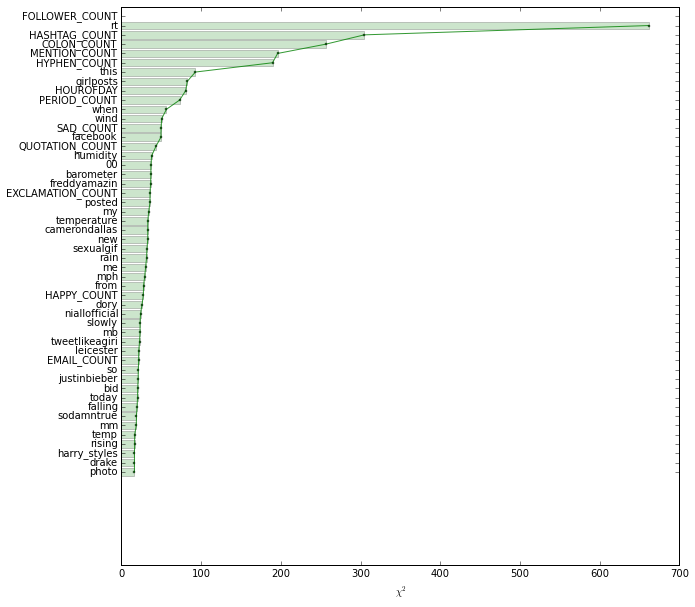

In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#Make a pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

vectorizer = NoUrls_CountVectorizer(ngram_range = (1,1), binary =True,
                                            min_df=2, stop_words=stop, strip_accents='ascii')
features = FeatureUnion([
        ('binary_unigram', Pipeline([ 
            ('extract', ColumnExtractor(colName = 'Text')),
            ('vectorizer',  vectorizer )
        ])),
         ('semicolon_count', Pipeline([
            ('extract', PunctuationCount(punctuation = ';')),
            ('normalize',   NormalizeShape()),
        ])),
         ('colon_count', Pipeline([
            ('extract', PunctuationCount(punctuation = ':')),
            ('normalize',   NormalizeShape()),
        ])),
        ('questionmark_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '?')),
            ('normalize',   NormalizeShape()),
        ])),
        ('exclamation_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '!')),
            ('normalize',   NormalizeShape()),
        ])),
        ('hyphen_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '-')),
            ('normalize',   NormalizeShape()),
        ])),
        ('period_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '.')),
            ('normalize',   NormalizeShape()),
        ])),
         ('quotation_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '"')),
            ('normalize',   NormalizeShape()),
        ])),
         ('apostrophe_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '\'')),
            ('normalize',   NormalizeShape()),
        ])),
         ('sad_count', Pipeline([
            ('extract', SadCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('happy_count', Pipeline([
            ('extract', HappyCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('phone_count', Pipeline([
            ('extract', PhoneCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('email_count', Pipeline([
            ('extract', EmailCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('hashtag_count', Pipeline([
            ('extract', HashTagCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('mention_count', Pipeline([
            ('extract', MentionCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('link_count', Pipeline([
            ('extract', ColumnExtractor(colName = 'LinkCount')),
            ('normalize',   NormalizeShape()),
        ])),
        ('hourofday', Pipeline([
            ('gethour', HourOfDayTransformer()),
            ('normalize',   NormalizeShape()),
        ])),
        ('follower_count', Pipeline([
            ('extract', FollowersTransformer()),
            ('normalize',   NormalizeShape()),
        ]))
    ])
        
X = features.fit_transform(df, df["Viral"])
print X.shape

print len(vectorizer.get_feature_names())
additional_features=[]
temp = ["semicolon_count", "colon_count", "questionmark_count", 
                       "exclamation_count", "hyphen_count", "period_count", 
                      "quotation_count", "apostrophe_count", "sad_count", "happy_count",
                      "phone_count", "email_count", "hashtag_count", "mention_count",
                      "link_count", "hourofday", "follower_count"]
for item in temp:
    item = item.upper()
    additional_features.append(item)
feature_names = vectorizer.get_feature_names() + additional_features
print len(feature_names)

chi2score = chi2(X, df["Viral"])[0]

from pylab import barh,plot,yticks,show,grid,xlabel,figure
figure(figsize=(10,10))
wscores = zip(feature_names, chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
k=50
topchi2 = zip(*wchi2[-k:])
x = range(len(topchi2[1]))
labels = topchi2[0]
barh(x,topchi2[1],align='center',alpha=.2,color='g')
plot(topchi2[1],x,'-o',markersize=2,alpha=.8,color='g')
yticks(x,labels)
xlabel('$\chi^2$')
show()

In [24]:
#Note score went down when including timeofday

#Make a pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import time

t0 = time.time()

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('binary_unigram', Pipeline([ 
            ('extract', ColumnExtractor(colName = 'Text')),
            ('vectorizer',   NoUrls_CountVectorizer(ngram_range = (1,1), binary =True,
                                            min_df=2, stop_words=stop, strip_accents='ascii'))
        ])),
         ('semicolon_count', Pipeline([
            ('extract', PunctuationCount(punctuation = ';')),
            ('normalize',   NormalizeShape()),
        ])),
         ('colon_count', Pipeline([
            ('extract', PunctuationCount(punctuation = ':')),
            ('normalize',   NormalizeShape()),
        ])),
        ('questionmark_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '?')),
            ('normalize',   NormalizeShape()),
        ])),
        ('exclamation_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '!')),
            ('normalize',   NormalizeShape()),
        ])),
        ('hyphen_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '-')),
            ('normalize',   NormalizeShape()),
        ])),
        ('period_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '.')),
            ('normalize',   NormalizeShape()),
        ])),
         ('quotation_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '"')),
            ('normalize',   NormalizeShape()),
        ])),
         ('apostrophe_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '\'')),
            ('normalize',   NormalizeShape()),
        ])),
         ('sad_count', Pipeline([
            ('extract', SadCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('happy_count', Pipeline([
            ('extract', HappyCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('phone_count', Pipeline([
            ('extract', PhoneCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('email_count', Pipeline([
            ('extract', EmailCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('hashtag_count', Pipeline([
            ('extract', HashTagCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('mention_count', Pipeline([
            ('extract', MentionCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('link_count', Pipeline([
            ('extract', ColumnExtractor(colName = 'LinkCount')),
            ('normalize',   NormalizeShape()),
        ])),
        ('follower_count', Pipeline([
            ('extract', FollowersTransformer()),
            ('normalize',   NormalizeShape()),
        ])),
        ('hourofday', Pipeline([
            ('gethour', HourOfDayTransformer()),
            ('normalize',   NormalizeShape()),
        ])),
    ])),
    ('feature_selector', SelectKBest(chi2, k=1000)),
    ('classifier',  svm.LinearSVC(penalty='l1', dual=False, C=0.1)) 
])

from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score
#adapted from http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html
k_fold = KFold(n=len(df), n_folds=10)
scores = []
confusion = np.array([[0, 0], [0, 0]])

for train_indices, test_indices in k_fold:
    #train_text = df.iloc[train_indices]['Text'].values
    train_text = df.iloc[train_indices]
    train_y = df.iloc[train_indices]['Viral'].values
    
    #test_text = df.iloc[test_indices]['Text'].values
    test_text = df.iloc[test_indices]
    test_y = df.iloc[test_indices]['Viral'].values
    
    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    #update totals
    confusion += confusion_matrix(test_y, predictions)
    score = f1_score(test_y, predictions, pos_label=1)
    scores.append(score)
t1 = time.time()
total = t1-t0
print('Time:', total)
print('Total tweets classified:', len(df))
print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)

X = pipeline.named_steps['features']
features = pipeline.named_steps['feature_selector']

('Time:', 15.79653000831604)
('Total tweets classified:', 4896)
('Score:', 0.84345513701544106)
Confusion matrix:
[[1583  793]
 [  88 2432]]


In [114]:
#Make kNN classifier
#NearestCentroid, KNeighborsClassifier
from sklearn import neighbors
import time

t0 = time.time()

name = "kNN"
# classifier = neighbors.
# KNeighborsClassifier(n_neighbors = 10)
# classifier.fit(train_features, train_labels)

#Make a pipeline
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer',   NoUrls_CountVectorizer(ngram_range = (1,1), binary =True,
                                    min_df=1, stop_words=stop, strip_accents='ascii')),
    ('classifier',  neighbors.KNeighborsClassifier(n_neighbors = 4)) ])

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('binary_unigram', Pipeline([ 
            ('extract', ColumnExtractor(colName = 'Text')),
            ('vectorizer',   NoUrls_CountVectorizer(ngram_range = (1,1), binary =True,
                                            min_df=2, stop_words=stop, strip_accents='ascii'))
        ])),
         ('semicolon_count', Pipeline([
            ('extract', PunctuationCount(punctuation = ';')),
            ('normalize',   NormalizeShape()),
        ])),
         ('colon_count', Pipeline([
            ('extract', PunctuationCount(punctuation = ':')),
            ('normalize',   NormalizeShape()),
        ])),
        ('questionmark_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '?')),
            ('normalize',   NormalizeShape()),
        ])),
        ('exclamation_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '!')),
            ('normalize',   NormalizeShape()),
        ])),
        ('hyphen_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '-')),
            ('normalize',   NormalizeShape()),
        ])),
        ('period_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '.')),
            ('normalize',   NormalizeShape()),
        ])),
         ('quotation_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '"')),
            ('normalize',   NormalizeShape()),
        ])),
         ('apostrophe_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '\'')),
            ('normalize',   NormalizeShape()),
        ])),
         ('sad_count', Pipeline([
            ('extract', SadCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('happy_count', Pipeline([
            ('extract', HappyCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('phone_count', Pipeline([
            ('extract', PhoneCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('email_count', Pipeline([
            ('extract', EmailCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('hashtag_count', Pipeline([
            ('extract', HashTagCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('mention_count', Pipeline([
            ('extract', MentionCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('link_count', Pipeline([
            ('extract', ColumnExtractor(colName = 'LinkCount')),
            ('normalize',   NormalizeShape()),
        ])),
        ('hourofday', Pipeline([
            ('gethour', HourOfDayTransformer()),
            ('normalize',   NormalizeShape()),
        ])),
    ])),
    ('classifier',  neighbors.KNeighborsClassifier(n_neighbors = 4))) 
])

from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score
#adapted from http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html
k_fold = KFold(n=len(df), n_folds=10)
scores = []
confusion = np.array([[0, 0], [0, 0]])

for train_indices, test_indices in k_fold:
    train_text = df.iloc[train_indices]['Text'].values
    train_y = df.iloc[train_indices]['Viral'].values
    
    test_text = df.iloc[test_indices]['Text'].values
    test_y = df.iloc[test_indices]['Viral'].values
    
    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    #update totals
    confusion += confusion_matrix(test_y, predictions)
    score = f1_score(test_y, predictions, pos_label=1)
    scores.append(score)
t1 = time.time()
total = t1-t0
print('Time:', total)
print('Total tweets classified:', len(df))
print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)

('Time:', 182.2849998474121)
('Total tweets classified:', 56131)
('Score:', 0.060369253454227688)
Confusion matrix:
[[54889    49]
 [ 1154    39]]


In [51]:
#Make Random Forest clasisifier
from sklearn import ensemble
# name = "randomforest"
# classifier = ensemble.RandomForestClassifier(n_estimators=100)
# classifier.fit(train_features, train_labels)

#Make a pipeline
from sklearn.pipeline import Pipeline
import time

t0 = time.time()
pipeline = Pipeline([
    ('vectorizer',   NoUrls_CountVectorizer(ngram_range = (1,1), binary =True,
                                    min_df=1, stop_words=stop, strip_accents='ascii')),
    ('classifier',  ensemble.RandomForestClassifier(n_estimators=10, max_features = 10)) ])

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('binary_unigram', Pipeline([ 
            ('extract', ColumnExtractor(colName = 'Text')),
            ('vectorizer',   NoUrls_CountVectorizer(ngram_range = (1,1), binary =True,
                                            min_df=2, stop_words=stop, strip_accents='ascii'))
        ])),
         ('semicolon_count', Pipeline([
            ('extract', PunctuationCount(punctuation = ';')),
            ('normalize',   NormalizeShape()),
        ])),
         ('colon_count', Pipeline([
            ('extract', PunctuationCount(punctuation = ':')),
            ('normalize',   NormalizeShape()),
        ])),
        ('questionmark_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '?')),
            ('normalize',   NormalizeShape()),
        ])),
        ('exclamation_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '!')),
            ('normalize',   NormalizeShape()),
        ])),
        ('hyphen_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '-')),
            ('normalize',   NormalizeShape()),
        ])),
        ('period_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '.')),
            ('normalize',   NormalizeShape()),
        ])),
         ('quotation_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '"')),
            ('normalize',   NormalizeShape()),
        ])),
         ('apostrophe_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '\'')),
            ('normalize',   NormalizeShape()),
        ])),
         ('sad_count', Pipeline([
            ('extract', SadCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('happy_count', Pipeline([
            ('extract', HappyCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('phone_count', Pipeline([
            ('extract', PhoneCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('email_count', Pipeline([
            ('extract', EmailCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('hashtag_count', Pipeline([
            ('extract', HashTagCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('mention_count', Pipeline([
            ('extract', MentionCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('link_count', Pipeline([
            ('extract', ColumnExtractor(colName = 'LinkCount')),
            ('normalize',   NormalizeShape()),
        ])),
        ('hourofday', Pipeline([
            ('gethour', HourOfDayTransformer()),
            ('normalize',   NormalizeShape()),
        ])),
    ])),
    ('classifier',  ensemble.RandomForestClassifier(n_estimators=10, max_features = 10))) 
])

from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score
#adapted from http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html
k_fold = KFold(n=len(df), n_folds=10)
scores = []
confusion = np.array([[0, 0], [0, 0]])

for train_indices, test_indices in k_fold:
    train_text = df.iloc[train_indices]['Text'].values
    train_y = df.iloc[train_indices]['Viral'].values
    
    test_text = df.iloc[test_indices]['Text'].values
    test_y = df.iloc[test_indices]['Viral'].values
    
    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    #update totals
    confusion += confusion_matrix(test_y, predictions)
    score = f1_score(test_y, predictions, pos_label=1)
    scores.append(score)
t1 = time.time()
total = t1-t0
print('Time:', total)
print('Total tweets classified:', len(df))
print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)

('Time:', 708.1180000305176)
('Total tweets classified:', 59983)
('Score:', 0.79366287749578812)
Confusion matrix:
[[57263    82]
 [  846  1792]]


In [52]:
#Make naive_bayes
from sklearn import naive_bayes
# name = "randomforest"
# classifier = ensemble.RandomForestClassifier(n_estimators=100)
# classifier.fit(train_features, train_labels)

#Make a pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
import time

t0 = time.time()
pipeline = Pipeline([
    ('vectorizer',   NoUrls_CountVectorizer(ngram_range = (1,1), binary =True,
                                    min_df=1, stop_words=stop, strip_accents='ascii')),
    ('classifier',  naive_bayes.BernoulliNB()) ])



pipeline = Pipeline([
    ('features', FeatureUnion([
        ('binary_unigram', Pipeline([ 
            ('extract', ColumnExtractor(colName = 'Text')),
            ('vectorizer',   NoUrls_CountVectorizer(ngram_range = (1,1), binary =True,
                                            min_df=2, stop_words=stop, strip_accents='ascii'))
        ])),
         ('semicolon_count', Pipeline([
            ('extract', PunctuationCount(punctuation = ';')),
            ('normalize',   NormalizeShape()),
        ])),
         ('colon_count', Pipeline([
            ('extract', PunctuationCount(punctuation = ':')),
            ('normalize',   NormalizeShape()),
        ])),
        ('questionmark_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '?')),
            ('normalize',   NormalizeShape()),
        ])),
        ('exclamation_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '!')),
            ('normalize',   NormalizeShape()),
        ])),
        ('hyphen_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '-')),
            ('normalize',   NormalizeShape()),
        ])),
        ('period_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '.')),
            ('normalize',   NormalizeShape()),
        ])),
         ('quotation_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '"')),
            ('normalize',   NormalizeShape()),
        ])),
         ('apostrophe_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '\'')),
            ('normalize',   NormalizeShape()),
        ])),
         ('sad_count', Pipeline([
            ('extract', SadCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('happy_count', Pipeline([
            ('extract', HappyCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('phone_count', Pipeline([
            ('extract', PhoneCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('email_count', Pipeline([
            ('extract', EmailCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('hashtag_count', Pipeline([
            ('extract', HashTagCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('mention_count', Pipeline([
            ('extract', MentionCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('link_count', Pipeline([
            ('extract', ColumnExtractor(colName = 'LinkCount')),
            ('normalize',   NormalizeShape()),
        ])),
        ('hourofday', Pipeline([
            ('gethour', HourOfDayTransformer()),
            ('normalize',   NormalizeShape()),
        ])),
    ])),
    ('classifier',  naive_bayes.BernoulliNB()) 
])

from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score
#adapted from http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html
k_fold = KFold(n=len(df), n_folds=10)
scores = []
confusion = np.array([[0, 0], [0, 0]])

for train_indices, test_indices in k_fold:
    #train_text = df.iloc[train_indices]['Text'].values
    train_text = df.iloc[train_indices]
    train_y = df.iloc[train_indices]['Viral'].values
    
    #test_text = df.iloc[test_indices]['Text'].values
    test_text = df.iloc[test_indices]
    test_y = df.iloc[test_indices]['Viral'].values
    
    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    #update totals
    confusion += confusion_matrix(test_y, predictions)
    score = f1_score(test_y, predictions, pos_label=1)
    scores.append(score)
t1 = time.time()
total = t1-t0
print('Time:', total)
print('Total tweets classified:', len(df))
print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)

('Time:', 235.39699983596802)
('Total tweets classified:', 56131)
('Score:', 0.85985592153478607)
Confusion matrix:
[[27375  2847]
 [ 4208 21701]]


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('binary_unigram', Pipeline([ 
            ('extract', ColumnExtractor(colName = 'Text')),
            ('vectorizer',   NoUrls_CountVectorizer(ngram_range = (1,1), binary =True,
                                            min_df=2, stop_words=stop, strip_accents='ascii'))
        ])),
         ('semicolon_count', Pipeline([
            ('extract', PunctuationCount(punctuation = ';')),
            ('normalize',   NormalizeShape()),
        ])),
         ('colon_count', Pipeline([
            ('extract', PunctuationCount(punctuation = ':')),
            ('normalize',   NormalizeShape()),
        ])),
        ('questionmark_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '?')),
            ('normalize',   NormalizeShape()),
        ])),
        ('exclamation_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '!')),
            ('normalize',   NormalizeShape()),
        ])),
        ('hyphen_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '-')),
            ('normalize',   NormalizeShape()),
        ])),
        ('period_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '.')),
            ('normalize',   NormalizeShape()),
        ])),
         ('quotation_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '"')),
            ('normalize',   NormalizeShape()),
        ])),
         ('apostrophe_count', Pipeline([
            ('extract', PunctuationCount(punctuation = '\'')),
            ('normalize',   NormalizeShape()),
        ])),
         ('sad_count', Pipeline([
            ('extract', SadCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('happy_count', Pipeline([
            ('extract', HappyCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('phone_count', Pipeline([
            ('extract', PhoneCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('email_count', Pipeline([
            ('extract', EmailCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('hashtag_count', Pipeline([
            ('extract', HashTagCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('mention_count', Pipeline([
            ('extract', MentionCount()),
            ('normalize',   NormalizeShape()),
        ])),
        ('link_count', Pipeline([
            ('extract', ColumnExtractor(colName = 'LinkCount')),
            ('normalize',   NormalizeShape()),
        ])),
        ('hourofday', Pipeline([
            ('gethour', HourOfDayTransformer()),
            ('normalize',   NormalizeShape()),
        ])),
    ]))
])
X = pipeline.fit(df, df["Viral"])
print X.shape
print X.columns



In [ ]:
chi2score = chi2(train_fea, df["Viral"])[0]

from pylab import barh,plot,yticks,show,grid,xlabel,figure
figure(figsize=(10,20))
wscores = zip(vectorizer.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
k=100
topchi2 = zip(*wchi2[-k:])
x = range(len(topchi2[1]))
labels = topchi2[0]
barh(x,topchi2[1],align='center',alpha=.2,color='g')
plot(topchi2[1],x,'-o',markersize=2,alpha=.8,color='g')
yticks(x,labels)
xlabel('$\chi^2$')
show()